# License Plate Identification

In [7]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import mlflow
import os

## Import data

In [ ]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="O3j38CrKDFImF9Vsz0Mn")
project = rf.workspace("floor-plan-ai-extraction").project("license-plate-recognition-rxg4e-mmjvn")
version = project.version(1)
dataset = version.download("yolov11")
                

  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio 1.18.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-1 in yolov11:: 100%|██████████| 20262/20262 [00:14<00:00, 1366.43it/s]


## Train yolo

In [ ]:

!yolo detect train data=License-Plate-Recognition-1/data.yaml model=yolo11m.pt epochs=100 imgsz=510 batch=16 workers=8 name=first_steps val=True


## Metrics

In [4]:
from ultralytics import YOLO

model = YOLO("runs/detect/first_steps/weights/best.pt")

results = model.val(
    data="License-Plate-Recognition-1/data.yaml",
    imgsz=510,
    batch=16,
    split="val",   # uses val split from your yaml
)


WARNING imgsz=[510] must be multiple of max stride 32, updating to [512]
Ultralytics 8.3.152  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 75.2110.0 MB/s, size: 39.2 KB)


val: Scanning C:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\labels.cache... 1521 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1521/1521 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:17<00:00,  5.37it/s]


                   all       1521       1634      0.989      0.941      0.975      0.725
Speed: 0.1ms preprocess, 6.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val


In [5]:
print("mAP50-95:", results.box.map)      # mAP@[.5:.95]
print("mAP50:   ", results.box.map50)    # mAP@0.5
print("mAP75:   ", results.box.map75)    # mAP@0.75
print("per-class mAP:", results.box.maps)  # list, one per class

mAP50-95: 0.7252979761407841
mAP50:    0.974735502104889
mAP75:    0.8513111556878987
per-class mAP: [     0.7253]


In [25]:
metrics = {}

metrics['precision'] = results.box.p     # one row per class
metrics['recall'] = results.box.r     # one row per class
metrics['f1'] = results.box.f1     # one row per class
metrics['mAP50-95'] = results.box.map     # one row per class
metrics['mAP50'] = results.box.map50     # one row per class
metrics['mAP75'] = results.box.map75     # one row per class

import pandas as pd
metrics_df = pd.DataFrame(metrics)


In [26]:
metrics_df

,precision,recall,f1,mAP50-95,mAP50,mAP75
0,0.98907,0.941459,0.964677,0.725298,0.974736,0.851311


## Conect to MLFlow

In [27]:
mlflow.set_experiment("license_plate_detection")
mlflow.set_tracking_uri("file:mlruns")  # local storage

MODEL_PATH = "runs/detect/first_steps/weights/best.pt"
DATASET_DIR = "License-Plate-Recognition-1"  # your dataset folder
DATA_YAML = "License-Plate-Recognition-1/data.yaml"

with mlflow.start_run(run_name="retro_import_first_steps"):
    # -- Params --
    mlflow.log_params({
        "model_path" : MODEL_PATH,
        "data_yaml": DATA_YAML,
        "model_name": "first_steps",
        "task" : "license_plate_detection",
        "epochs": 100,
        "imgsz": 510,
        "batch": 16,
        "base_model": "yolo11m.pt"
    })

    # -- Metrics --
    plate_index = 0  # Single class

    mlflow.log_metric("plate_precision", float(metrics_df.loc[plate_index, "precision"]))
    mlflow.log_metric("plate_recall",    float(metrics_df.loc[plate_index, "recall"]))
    mlflow.log_metric("plate_f1",        float(metrics_df.loc[plate_index, "f1"]))
    mlflow.log_metric("plate_mAP50_95",  float(metrics_df.loc[plate_index, "mAP50-95"]))
    mlflow.log_metric("plate_mAP50",     float(metrics_df.loc[plate_index, "mAP50"]))
    mlflow.log_metric("plate_mAP75",     float(metrics_df.loc[plate_index, "mAP75"]))

    # -- Model artifact --
    mlflow.log_artifact(MODEL_PATH, artifact_path="model")

    # Log complete dataset folder
    mlflow.log_artifacts(DATASET_DIR, artifact_path="dataset")
    
print("Model registered to MLflow.")

Model registered to MLflow.


## Inference

In [1]:
%matplotlib inline


In [4]:
model = YOLO("runs/detect/first_steps/weights/best.pt")
test_img = r"License-Plate-Recognition-1\valid\images\24-s-l300_jpg.rf.6fea3be7cf32808f5903ab3f8bb140c2.jpg"
results = model(test_img)
xyxy = results[0].boxes.xyxy.cpu().numpy()


image 1/1 c:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\images\24-s-l300_jpg.rf.6fea3be7cf32808f5903ab3f8bb140c2.jpg: 512x384 3 License_Plates, 104.1ms
Speed: 3.8ms preprocess, 104.1ms inference, 227.5ms postprocess per image at shape (1, 3, 512, 384)


In [58]:
xyxy

array([[     5.2215,      195.62,      204.67,      295.46],
       [     8.6095,      96.372,      203.89,      193.05],
       [     12.199,      3.2674,      203.53,      94.284]], dtype=float32)

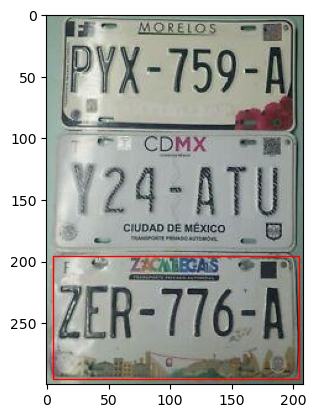

In [ ]:
im = Image.open(test_img)

# Display the image
plt.imshow(im)

ax = plt.gca()

# Create a Rectangle patch

x1, y1, x2, y2 = xyxy[0]
w = x2 - x1
h = y2 - y1

rect = patches.Rectangle((x1, y1), w, h , linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


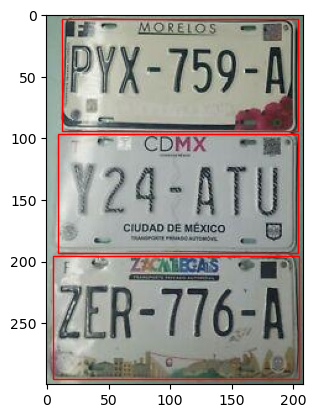

In [8]:
def draw_bounding_boxes(image_path, boxes):
    im = Image.open(image_path)
    plt.imshow(im)
    ax = plt.gca()

    for box in boxes:
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h , linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
draw_bounding_boxes(test_img, xyxy)

## Random select

In [9]:

## random get images from valid folder
import random
import glob

def get_random_image_from_folder(folder_path):
    image_files = glob.glob(os.path.join(folder_path, "*.jpg"))
    return random.choice(image_files)


image 1/1 c:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\images\CarLongPlateGen3170_jpg.rf.2a456345088c324f2e40e590ec410d8b.jpg: 352x512 1 License_Plate, 22.7ms
Speed: 1.7ms preprocess, 22.7ms inference, 2.6ms postprocess per image at shape (1, 3, 352, 512)


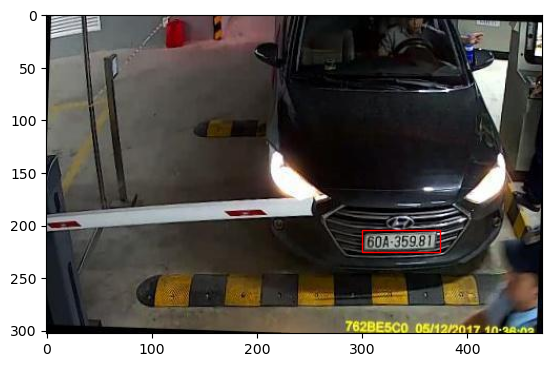

In [41]:
random_image = get_random_image_from_folder(r"License-Plate-Recognition-1\valid\images")
draw_bounding_boxes(random_image, model(random_image)[0].boxes.xyxy.cpu().numpy())

## Compress model


In [77]:
from ultralytics import YOLO

model = YOLO("runs/detect/first_steps/weights/best.pt")
model.export(format="onnx")


Ultralytics 8.3.152  Python-3.10.18 torch-2.5.1+cu121 CPU (AMD Ryzen 7 8845HS w/ Radeon 780M Graphics)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs

PyTorch: starting from 'runs\detect\first_steps\weights\best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 5, 5376) (38.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 244.5/244.5 MB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 6.3/6.3 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:------------- 1/9 [sympy]
      Successfully uninstalled sympy-1.13.1 1/9 [sympy]
  Attempting uninstall: onnx--------------- 2/9 [pyreadline3]
    Found existing installation: onnx 1.1

'runs\\detect\\first_steps\\weights\\best.onnx'

WARNING Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.

image 1/1 c:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\images\CarLongPlate859_jpg.rf.ac61dbfce358c1a7044cc43a495f3811.jpg: 352x512 1 License_Plate, 66.4ms
Speed: 2.7ms preprocess, 66.4ms inference, 2.8ms postprocess per image at shape (1, 3, 352, 512)


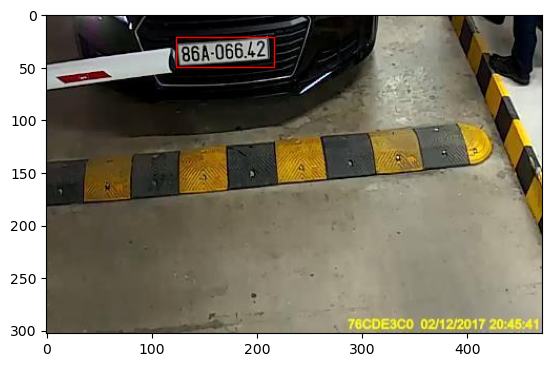

In [76]:
from ultralytics import YOLO
onnx_model = YOLO("Models/basic_run.onnx")
random_image_path = get_random_image_from_folder(r"License-Plate-Recognition-1\valid\images")
draw_bounding_boxes(random_image_path, model(random_image_path)[0].boxes.xyxy.cpu().numpy())

## OCR

In [ ]:
# !pip install paddleocr
# !pip install paddlepaddle

In [43]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False)
results = ocr.predict(random_image)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\alexc\.paddlex\official_models\PP-OCRv5_server_det`.


Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\alexc\.paddlex\official_models\PP-OCRv5_server_rec`.


In [77]:
import cv2
boxes = model(random_image_path)[0].boxes.xyxy.cpu().numpy()

for i, box in enumerate(boxes):
    x1, y1, x2, y2 =  map(int, box.tolist())
    img = cv2.imread(random_image_path) 
    crop = img[y1:y2, x1:x2]
    plates_results = ocr.predict(crop)
    print(plates_results[0]['rec_texts'])




image 1/1 c:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\images\CarLongPlate859_jpg.rf.ac61dbfce358c1a7044cc43a495f3811.jpg: 352x512 1 License_Plate, 64.5ms
Speed: 2.6ms preprocess, 64.5ms inference, 2.4ms postprocess per image at shape (1, 3, 352, 512)
['86A-066.42']


In [ ]:
print(plates_results[0]['rec_texts'])

['83-E1', '016.92']


In [44]:
for res in results:
    print(res['rec_texts'])
    print(res['rec_scores'])

['51A-012.04', '565716BE04/12/201707:55:11']
[0.9804288148880005, 0.9675301909446716]


image 1/1 c:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\images\CarLongPlateGen1958_jpg.rf.0e1d4986441aac35c56056423e89be87.jpg: 352x512 1 License_Plate, 65.0ms
Speed: 2.7ms preprocess, 65.0ms inference, 2.9ms postprocess per image at shape (1, 3, 352, 512)


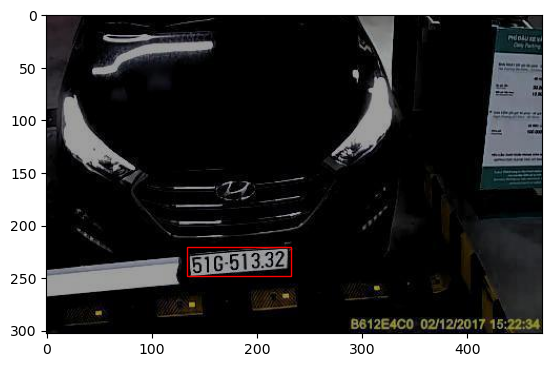


image 1/1 c:\Users\alexc\Documents\GitHub\License-plate-identification\License-Plate-Recognition-1\valid\images\CarLongPlateGen1958_jpg.rf.0e1d4986441aac35c56056423e89be87.jpg: 352x512 1 License_Plate, 64.6ms
Speed: 1.8ms preprocess, 64.6ms inference, 3.1ms postprocess per image at shape (1, 3, 352, 512)
['51G-513.32']


In [ ]:
# TODO: rename function and consise code
random_image_path = get_random_image_from_folder(r"License-Plate-Recognition-1\valid\images")
draw_bounding_boxes(random_image_path, model(random_image_path)[0].boxes.xyxy.cpu().numpy())
boxes = model(random_image_path)[0].boxes.xyxy.cpu().numpy()

for i, box in enumerate(boxes):
    x1, y1, x2, y2 =  map(int, box.tolist())
    img = cv2.imread(random_image_path) 
    crop = img[y1:y2, x1:x2]
    plates_results = ocr.predict(crop)
    print(plates_results[0]['rec_texts'])


In [ ]:
# TODO: integrate detection and OCR results in a sinlgle funciton
# TODO : install different ocr model
# TODO : clean notebook